# 05b Fit a RandomForest model from DC2 simulations with standardization

- author Sylvie Dagoret-Campagne
- creation date : 2024/03/22
- last verification : 2024/03/22 (CCIN2P3 - kernel conda_desc_py310)

### Use libraries

- getObsAtmo : for atmosphere emulation : https://github.com/LSSTDESC/getObsAtmo/tree/main
- rubinsimphot : a simplified version of rubin_sim : https://github.com/sylvielsstfr/rubinsimphot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
import copy

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import getpass
import datetime

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
props = dict(boxstyle='round', facecolor='yellow', alpha=0.3)

# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [18, 10],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

In [2]:
from scipy import interpolate
from astropy import constants as const
from astropy import units as u
from joblib import dump, load
import pickle

In [3]:
import warnings                      # imports the warnings library
import gc                            # imports python's garbage collector
# Ignore warnings
from astropy.units import UnitsWarning
warnings.simplefilter("ignore", category=UnitsWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import rubin sim
- import libPhotometricCorrections : encapsulate uninteresting calculation details

### libradtran emulator

In [4]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.1


In [5]:
from getObsAtmo import ObsAtmo
emul = ObsAtmo()

LSST site name validated as LSST observatory


In [6]:
WL = emul.GetWL()

In [7]:
import sys
sys.path.append('../lib')
import libAtmosphericFit

LSST site name validated as LSST observatory


In [8]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections import *

LSST site name validated as LSST observatory


https://github.com/lsst/rubin_sim_notebooks/blob/main/photometry/calculating_snr.ipynb

In [9]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir
from rubinsimphot.phot_utils import PhotometricParameters 
from rubinsimphot.site_models import SeeingModel
from rubinsimphot.phot_utils import signaltonoise
from rubinsimphot.phot_utils import calc_neff

In [10]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [11]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

In [12]:
seeing_model = SeeingModel()
def seeing_at_X(obs_filter, obs_X, atmospheric_seeing_500nm=None, seeing_zenith=None):
    "Return FWHMeff in `obs_filter` at `obs_X`, providing either the seeing @ zenith (in filter) or the FWHM_500"
    if atmospheric_seeing_500nm is not None:
        idx = filterlist.index(obs_filter)
        fwhm_eff = seeing_model(atmospheric_seeing_500nm, obs_X)['fwhmEff'][idx]
    elif seeing_zenith is not None:
        # assume seeing_zenith is in the filter of choice and just approximate for airmass 
        airmass_correction = np.power(obs_X, 0.6)
        fwhm_eff = 1.16 * seeing_zenith * airmass_correction
    else:
        raise ValueErorr('Must specify atmospheric_seeing_500nm or seeing_zenith')
    return fwhm_eff

In [13]:
def calc_snr(sed, obs_filter, obs_skymag, obs_fwhm_eff, obs_X, 
             ref_filter, ref_mag, 
             exptime=15, nexp=2, verbose=False):
    obs_sky = scale_sky(obs_skymag, obs_filter)
    lsst_x = throughput_at_X(obs_X)
    scaled_sed = scale_sed(ref_mag, ref_filter, sed)
    photParams = set_photometric_parameters(exptime, nexp)
    snr = SignalToNoise.calc_snr_sed(scaled_sed, lsst_x[obs_filter], 
                                    obs_sky, lsst_hardware[obs_filter], 
                                    photParams, fwhm_eff=obs_fwhm_eff, 
                                    verbose=verbose)
    return snr

## Configuration

In [14]:
path_rubin_sim_throughput=os.path.join(get_data_dir(),"throughputs/baseline")

In [15]:
darksky = Sed()
darksky.read_sed_flambda(os.path.join(path_rubin_sim_throughput, 'darksky.dat'))

In [16]:
index_sel = np.where(np.logical_and(darksky.wavelen>=WLMIN,darksky.wavelen<WLMAX))[0]
wav = darksky.wavelen[index_sel]
fll = darksky.flambda[index_sel]
darksel = Sed(wavelen=wav, flambda=fll)

Text(0, 0.5, '$F_\\lambda (\\lambda)$')

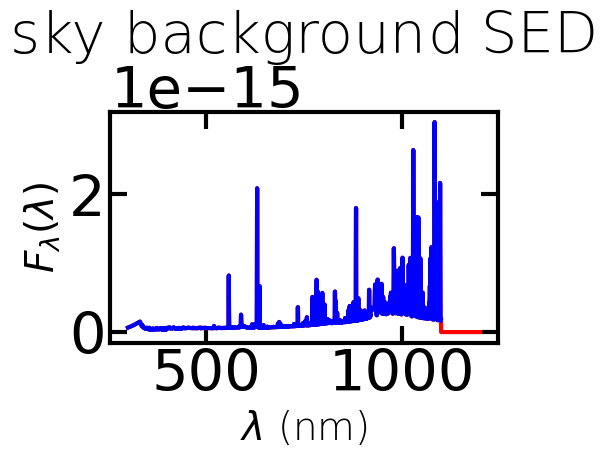

In [17]:
fig, axs = plt.subplots(1,1,figsize=(5,3))
axs.plot(darksky.wavelen,darksky.flambda,'r-')
axs.plot(darksel.wavelen,darksel.flambda,'b-')
axs.set_title("sky background SED")
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_ylabel("$F_\lambda (\lambda)$")

## Chose a Standard atmosphere

In [18]:
am0 =1.20    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.0 # Aerosol Angstrom exponent

### Initialisation of Atmospheric corrections

In [19]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/pbs/throng/lsst/users/dagoret/desc/2024/AtmosphericStuffs/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


### Check standard atmosphere

Text(0.5, 1.0, 'Standard atmosphere transmission')

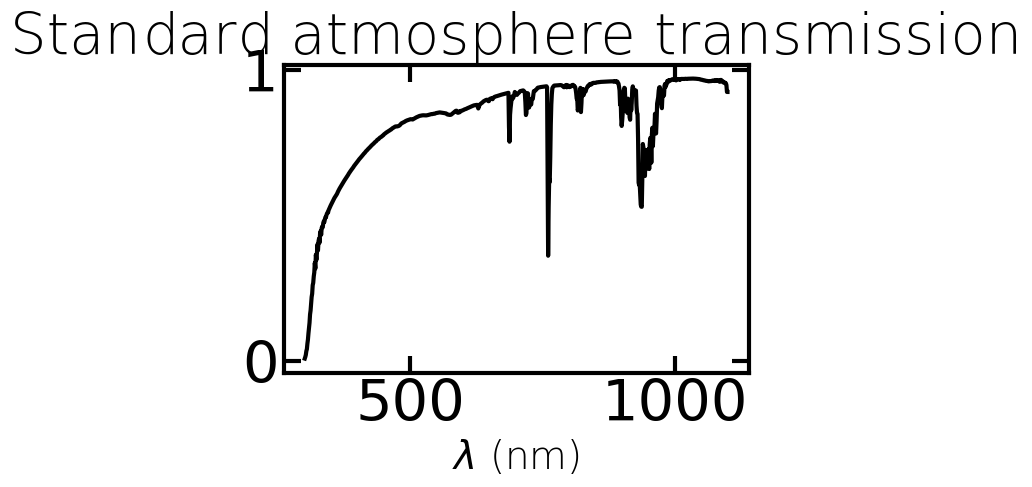

In [20]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

## Pickup an SED

In [21]:
# this will contain attributes calculated for each SED
df_SED = pd.DataFrame(columns=["name","type"])

In [22]:
datadir = get_data_dir()
#sedDir = '/Users/lynnej/other_repos/photometry_sample'
sedDir = os.path.join(datadir,'photometry_sample')

sedtypes = ['galaxies', 'quasar','photoZ_outliers','sn'] 
sedtypes_not_used = ['stars', 'white_dwarf']
sedtypes = sedtypes 

NSEDTYPES = len(sedtypes)

# dictionnary indexed by sed-name
seds = {}      # dictionnary that will contain the `rubin_sim` seds-Flambdas
sedsfnu = {}   # dictionnary that will contain the `rubin_sim` seds-Fnu
sedtypeslists = {}  # dictionnary that contain the SED type
count_sed =0

# loop on SED type
for idx,s in enumerate(sedtypes):
    sedtypelist = []
    # loop on object sed in SED type list
    filenames = os.listdir(os.path.join(sedDir, s))
    for f in filenames:
        name = f.replace('.dat', '').replace('.sed', '')
        
        if name == "m3.0Full":
            continue
            
        seds[name] = Sed()
        seds[name].read_sed_flambda(os.path.join(sedDir, s, f))
        sedsfnu[name]= Sed()
    
        # save the name of the sed in the list
        sedtypelist.append(name) 
        df_SED.loc[count_sed] = [name,s]
        count_sed+=1
        
    # save the above list in a dictionary
    sedtypeslists[s] =  sedtypelist
        


In [23]:
df_SED=df_SED.set_index('name')
df_SED

,type
name,
Sa_template_norm,galaxies
Ell2_template_norm,galaxies
Sdm_template_norm0,galaxies
quasar,quasar
xspec_172,photoZ_outliers
xspec_90,photoZ_outliers
xspec_173,photoZ_outliers
xspec_91,photoZ_outliers
xspec_176,photoZ_outliers


In [24]:
#sed_name = 'xspec_173'
#sed_name = 'quasar'
sed_name = 'Sa_template_norm'
#sed_name = 'Sdm_template_norm0'
#sed_name = 'Ell2_template_norm'
#sed_name = 'sn1a_10.0'
#sed_name = 'sn1a_15.0'
#sed_name = 'sn1a_20.0'

In [25]:
z=0
seds[sed_name].redshift_sed(z)

In [26]:
# Scale spectrum and recalculate magnitudes.
y = 20.0

flux_norm = seds[sed_name].calc_flux_norm(y, pc.bandpass_total_std['y'])
seds[sed_name].multiply_flux_norm(flux_norm)

In [27]:
all_redshifts = np.arange(0,3.5,0.5)
all_seds = []
all_seds_name = []
NSEDS = len(all_redshifts)
hls_colors = sns.color_palette("hls", NSEDS)
for idx,z in enumerate(all_redshifts):
    the_sed = copy.deepcopy(seds[sed_name])
    the_sed.redshift_sed(z)
    all_seds.append(copy.deepcopy(the_sed))
    the_sed_name = f"{sed_name}_{idx}_z{z:.1f}"
    all_seds_name.append(the_sed_name)

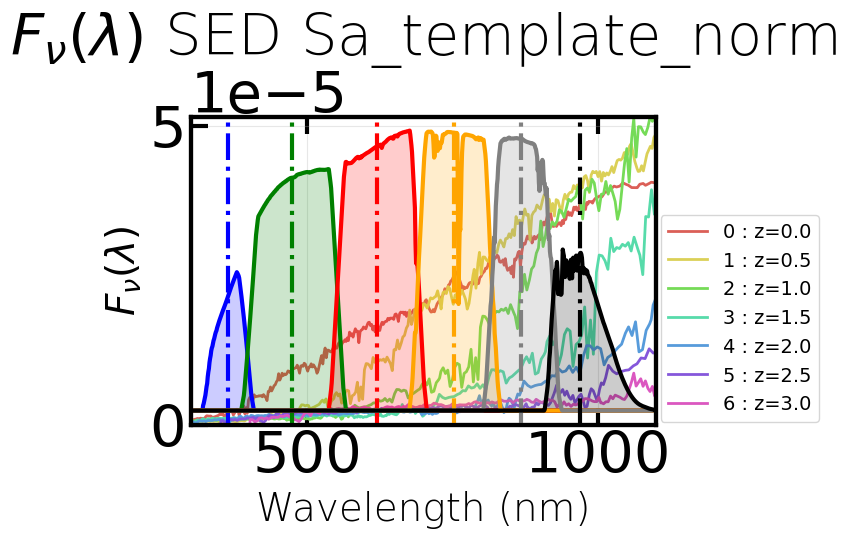

In [28]:
# Plot the seds
all_fmax = np.zeros(NSEDS)
fig, ax = plt.subplots(1,1,figsize=(6,4))

for idx,the_sed in enumerate(all_seds):
    
    wavel,fnu = the_sed.get_sed_fnu()
    z=all_redshifts[idx] 
    label = f"{idx} : z={z:.1f}"
    
    ax.plot(wavel, fnu,"-",color=hls_colors[idx],label=label,lw=2)
    
    indexes_sel = np.where(np.logical_and(wavel>WLMIN,wavel<WLMAX))[0]
    flmax = np.max(fnu[indexes_sel])
    all_fmax[idx] = flmax
    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
fmax=np.max(all_fmax)
ax.set_ylim(0,fmax)

ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\\nu (\lambda)$")
ax.set_title("$F_\\nu (\lambda)$" + f" SED {sed_name}")

indexes_sel = np.where(np.logical_and(wavel>WLMIN,wavel<WLMAX))[0]
flmax = np.max(fnu[indexes_sel])

                       

ax2 = ax.twinx()
for index,f in enumerate(filter_tagnames):
    
    ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    ax2.set_yticks([])
    

# Calculations of magnitude and ADC in standard passband

In [29]:
mags_std = {}
for index,f in enumerate(filter_tagnames) :
    mags_std[f] = seds[sed_name].calc_mag(pc.bandpass_total_std[f])
    
pd.DataFrame(mags_std, index=[sed_name]).T

,Sa_template_norm
u,23.164117
g,21.581631
r,20.848641
i,20.509666
z,20.226130
y,20.000000


In [30]:
photoparams = set_photometric_parameters(15, 2 , readnoise=None)
adcs_std = {}
for index,f in enumerate(filter_tagnames) :
    adcs_std[f] = seds[sed_name].calc_adu(pc.bandpass_total_std[f],photoparams)
    
pd.DataFrame(adcs_std, index=[sed_name]).T

,Sa_template_norm
u,420.558634
g,6611.446987
r,10757.678307
i,11254.434970
z,10134.695435
y,6007.676529


# Create a series of observations

- vary precipitable water vapor
- keep airmass at 1.2
- other atmospheric parameters are kept constants

In [31]:
PWVMIN = 1
PWVMAX = 9
DPWV= PWVMAX-PWVMIN 
NOBS = 100

In [32]:
all_pwv = DPWV*np.random.rand(NOBS) + PWVMIN

In [33]:
pc.CalculateMultiObs(am0,all_pwv,oz0,tau0,beta0)

/pbs/throng/lsst/users/dagoret/desc/2024/AtmosphericStuffs/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


## Simulate the observations

In [34]:
# constant in zero point
F0AB = 3631*(1*u.Jy).cgs.value
Z0PTconst = 2.5*np.log10((F0AB*photoparams.effarea*photoparams.nexp*photoparams.exptime)/(photoparams.gain*const.h.cgs.value))

In [35]:
2.5*np.log10(3631)

8.90006562228223

In [36]:
2.5*np.log10((1*u.Jy).cgs.value)

-57.5

In [37]:
# constant in zero point
#F0AB = 3631*(1*u.Jy).value
#Z0PTconst = 2.5*np.log10(photoparams.gain*const.h.value/(F0AB*photoparams.effarea*photoparams.nexp*photoparams.exptime))

In [38]:
df = pd.DataFrame(columns=['count','sed', 'redshift','iobs','pwv',
                           'adcstd_u', 'adcstd_g','adcstd_r','adcstd_i','adcstd_z','adcstd_y',
                           'adcobs_u', 'adcobs_g','adcobs_r','adcobs_i','adcobs_z','adcobs_y',
                           'mistd_u','mistd_g','mistd_r','mistd_i','mistd_z','mistd_y',
                           'miobs_u','miobs_g','miobs_r','miobs_i','miobs_z','miobs_y',
                           'II0ratio_u','II0ratio_g','II0ratio_r','II0ratio_i','II0ratio_z','II0ratio_y',
                           'II1sub_u','II1sub_g','II1sub_r','II1sub_i','II1sub_z','II1sub_y',
                           'magratioII0_u','magratioII0_g','magratioII0_r','magratioII0_i','magratioII0_z','magratioII0_y',
                           'magstd_u','magstd_g','magstd_r','magstd_i','magstd_z','magstd_y',
                           'magobs_u','magobs_g','magobs_r','magobs_i','magobs_z','magobs_y',
                           'z0pt_u','z0pt_g','z0pt_r','z0pt_i','z0pt_z','z0pt_y' 
                          ])


In [39]:
# loop on SEDs
count=0
for idx_sed,the_sed in enumerate(all_seds):
    #loop on observations 
    for idx_obs,pwv in enumerate(all_pwv):
        # loop in filters
        magstd = np.zeros(NFILT)
        magobs = np.zeros(NFILT)
        adcstd = np.zeros(NFILT)
        adcobs = np.zeros(NFILT)
        mistd = np.zeros(NFILT)
        miobs = np.zeros(NFILT)
        ratioII0 = np.zeros(NFILT)
        subII1 = np.zeros(NFILT)
        magratioII0 = np.zeros(NFILT)
        II0std = np.zeros(NFILT)
        II1std = np.zeros(NFILT)
        Z0PT = np.zeros(NFILT)
        
        for ifilt,f in enumerate(filter_tagnames):
            # standard quanitites
            lsst_band_std = pc.bandpass_total_std[f]
            magstd[ifilt] = all_seds[idx_sed].calc_mag(lsst_band_std)
            adcstd[ifilt] = all_seds[idx_sed].calc_adu(lsst_band_std,photoparams)
            mistd[ifilt] = -2.5*np.log10(adcstd[ifilt])
            II0std[ifilt] = pc.all_II0_std[f]
            II1std[ifilt] = pc.all_II1_std[f]
            # zero point
            Z0PT[ifilt] = 2.5*np.log10(II0std[ifilt])+ Z0PTconst
                
            # non standard quantities    
            lsst_band_obs = pc.coll_bandpass_total_nonstd[idx_obs][f]  
            adcobs[ifilt] = all_seds[idx_sed].calc_adu(lsst_band_obs,photoparams)
            miobs[ifilt] = -2.5*np.log10(adcobs[ifilt])
            magobs[ifilt] = all_seds[idx_sed].calc_mag(lsst_band_obs)
            
            ratioII0[ifilt] = pc.allcollperfilter[f]["II0ratio_nonstd"][idx_obs]  
            subII1[ifilt] = pc.allcollperfilter[f]["II1sub_nonstd"][idx_obs] 
            magratioII0[ifilt] = 2.5*np.log10(ratioII0[ifilt])
        # fill for each observation 
        
        df.loc[count] = [count,all_seds_name[idx_sed], all_redshifts[idx_sed], idx_obs, pwv,
                          adcstd[0],adcstd[1],adcstd[2],adcstd[3],adcstd[4],adcstd[5],
                          adcobs[0],adcobs[1],adcobs[2],adcobs[3],adcobs[4],adcobs[5],
                          mistd[0],mistd[1],mistd[2],mistd[3],mistd[4],mistd[5],
                          miobs[0],miobs[1],miobs[2],miobs[3],miobs[4],miobs[5],
                          ratioII0[0],ratioII0[1],ratioII0[2],ratioII0[3],ratioII0[4],ratioII0[5],
                          subII1[0],subII1[1],subII1[2],subII1[3],subII1[4],subII1[5],
                          magratioII0[0],magratioII0[1],magratioII0[2],magratioII0[3],magratioII0[4],magratioII0[5],
                          magstd[0],magstd[1],magstd[2],magstd[3],magstd[4],magstd[5],
                          magobs[0],magobs[1],magobs[2],magobs[3],magobs[4],magobs[5],
                          Z0PT[0],Z0PT[1],Z0PT[2],Z0PT[3],Z0PT[4],Z0PT[5]  
                        ]
        
        count+=1
                          
        

In [40]:
df

,count,sed,redshift,iobs,pwv,adcstd_u,adcstd_g,adcstd_r,adcstd_i,adcstd_z,...,magobs_r,magobs_i,magobs_z,magobs_y,z0pt_u,z0pt_g,z0pt_r,z0pt_i,z0pt_z,z0pt_y
0,0,Sa_template_norm_0_z0.0,0.0,0,1.313815,420.558634,6611.446987,10757.678307,11254.434970,10134.695435,...,20.848616,20.509861,20.224447,20.003894,29.723683,31.132372,30.927937,30.637975,30.240657,29.446766
1,1,Sa_template_norm_0_z0.0,0.0,1,1.054878,420.558634,6611.446987,10757.678307,11254.434970,10134.695435,...,20.848614,20.509875,20.224302,20.004293,29.723683,31.132372,30.927937,30.637975,30.240657,29.446766
2,2,Sa_template_norm_0_z0.0,0.0,2,7.401474,420.558634,6611.446987,10757.678307,11254.434970,10134.695435,...,20.848656,20.509544,20.226981,19.998172,29.723683,31.132372,30.927937,30.637975,30.240657,29.446766
3,3,Sa_template_norm_0_z0.0,0.0,3,5.301722,420.558634,6611.446987,10757.678307,11254.434970,10134.695435,...,20.848643,20.509651,20.226246,19.999752,29.723683,31.132372,30.927937,30.637975,30.240657,29.446766
4,4,Sa_template_norm_0_z0.0,0.0,4,1.374794,420.558634,6611.446987,10757.678307,11254.434970,10134.695435,...,20.848616,20.509857,20.224480,20.003805,29.723683,31.132372,30.927937,30.637975,30.240657,29.446766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,695,Sa_template_norm_6_z3.0,3.0,95,7.513025,1.994385,1171.042474,1803.902220,1658.859991,1347.564376,...,22.787422,22.588630,22.416610,22.433424,29.723683,31.132372,30.927937,30.637975,30.240657,29.446766
696,696,Sa_template_norm_6_z3.0,3.0,96,1.209374,1.994385,1171.042474,1803.902220,1658.859991,1347.564376,...,22.787377,22.588130,22.417157,22.448772,29.723683,31.132372,30.927937,30.637975,30.240657,29.446766
697,697,Sa_template_norm_6_z3.0,3.0,97,2.651469,1.994385,1171.042474,1803.902220,1658.859991,1347.564376,...,22.787388,22.588261,22.416989,22.444048,29.723683,31.132372,30.927937,30.637975,30.240657,29.446766
698,698,Sa_template_norm_6_z3.0,3.0,98,5.319158,1.994385,1171.042474,1803.902220,1658.859991,1347.564376,...,22.787407,22.588475,22.416759,22.437610,29.723683,31.132372,30.927937,30.637975,30.240657,29.446766


# If does not calibrate with $II_b^{obs}/II_b^{std}$

Text(0.5, 1.05, '$m_i^{obs}-m_i^{std}$ (mag)for SED Sa_template_norm')

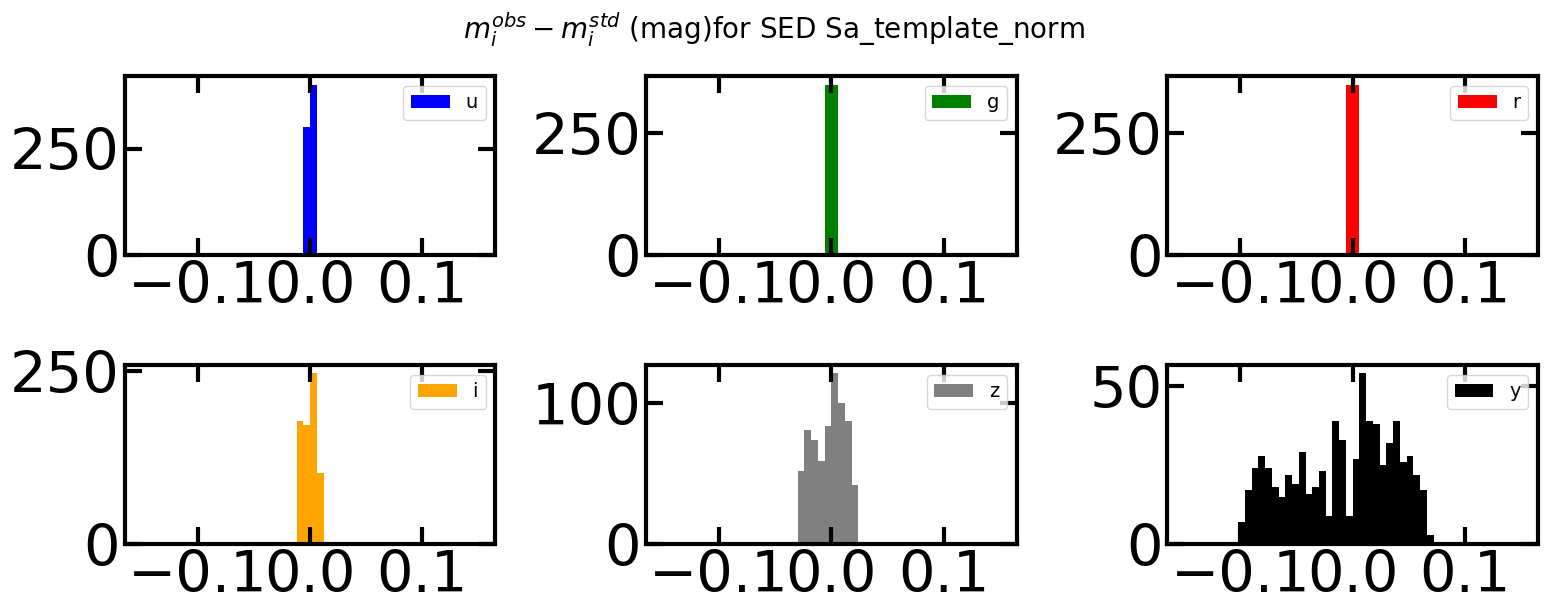

In [41]:
fig, ax = plt.subplots(2,3,figsize=(16,6))
# u
value = df["miobs_u"]-df["mistd_u"]
ax[0,0].hist(value,bins=50,range=(-0.15,0.15),facecolor=filter_color[0],label=filter_tagnames[0] )
# g
value = df["miobs_g"]-df["mistd_g"]
ax[0,1].hist(value,bins=50,range=(-0.15,0.15),facecolor=filter_color[1],label=filter_tagnames[1])
# r
value = df["miobs_r"]-df["mistd_r"]
ax[0,2].hist(value,bins=50,range=(-0.15,0.15),facecolor=filter_color[2],label=filter_tagnames[2])
# i
value = df["miobs_i"]-df["mistd_i"]
ax[1,0].hist(value,bins=50,range=(-0.15,0.15),facecolor=filter_color[3],label=filter_tagnames[3])
# z
value = df["miobs_z"]-df["mistd_z"]
ax[1,1].hist(value,bins=50,range=(-0.15,0.15),facecolor=filter_color[4],label=filter_tagnames[4])
#
value = df["miobs_y"]-df["mistd_y"]
ax[1,2].hist(value,bins=50,range=(-0.15,0.15),facecolor=filter_color[5],label=filter_tagnames[5])
for ix in range(3):
    for iy in range(2):
        ax[iy,ix].legend()
plt.tight_layout()
plt.suptitle("$m_i^{obs}-m_i^{std}$ (mag)"+ f"for SED {sed_name}",fontsize=20,y=1.05)

# If one calibrates with $II_b^{obs}/II_b^{std}$

- assume perfect pwv measurement

Text(0.5, 1.05, '$m_i^{obs} + 2.5\\log_{10}(II^{obs}/II^{std})-m_i^{std}$ (mag) for SED Sa_template_norm')

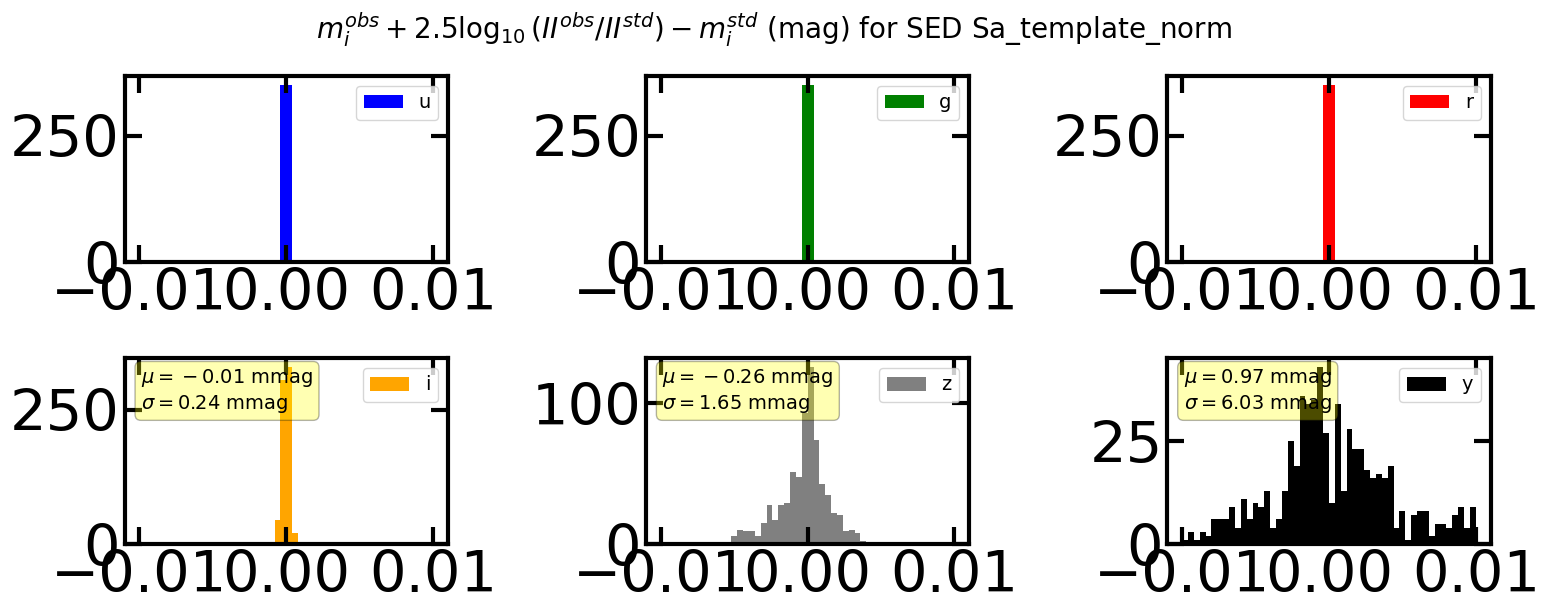

In [42]:
fig, ax = plt.subplots(2,3,figsize=(16,6))
# u
values = df["miobs_u"]+df["magratioII0_u"]-df["mistd_u"]
ax[0,0].hist(values,bins=50,range=(-0.01,0.01),facecolor=filter_color[0],label=filter_tagnames[0] )
# g
values = df["miobs_g"]+df["magratioII0_g"]-df["mistd_g"]
ax[0,1].hist(values,bins=50,range=(-0.01,0.01),facecolor=filter_color[1],label=filter_tagnames[1])
# r
values = df["miobs_r"]+df["magratioII0_r"]-df["mistd_r"]
ax[0,2].hist(values,bins=50,range=(-0.01,0.01),facecolor=filter_color[2],label=filter_tagnames[2])

# i
values = df["miobs_i"]+df["magratioII0_i"]-df["mistd_i"]
mean = values.describe()["mean"]*1000
std = values.describe()["std"]*1000
textstr = '\n'.join((
    r'$\mu=%.2f$ mmag' % (mean, ),
    r'$\sigma=%.2f$ mmag' % (std, )))
ax[1,0].hist(values,bins=50,range=(-0.01,0.01),facecolor=filter_color[3],label=filter_tagnames[3])
ax[1,0].text(0.05, 0.95, textstr, transform=ax[1,0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


#z
values = df["miobs_z"]+df["magratioII0_z"]-df["mistd_z"]
mean = values.describe()["mean"]*1000
std = values.describe()["std"]*1000
textstr = '\n'.join((
    r'$\mu=%.2f$ mmag' % (mean, ),
    r'$\sigma=%.2f$ mmag' % (std, )))
ax[1,1].hist(values,bins=50,range=(-0.01,0.01),facecolor=filter_color[4],label=filter_tagnames[4])
ax[1,1].text(0.05, 0.95, textstr, transform=ax[1,1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# y
values = df["miobs_y"]+df["magratioII0_y"]-df["mistd_y"]
mean = values.describe()["mean"]*1000
std = values.describe()["std"]*1000
textstr = '\n'.join((
    r'$\mu=%.2f$ mmag' % (mean, ),
    r'$\sigma=%.2f$ mmag' % (std, )))
ax[1,2].hist(values,bins=50,range=(-0.01,0.01),facecolor=filter_color[5],label=filter_tagnames[5])
ax[1,2].text(0.05, 0.95, textstr, transform=ax[1,2].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

for ix in range(3):
    for iy in range(2):
        ax[iy,ix].legend()
plt.tight_layout()
plt.suptitle("$m_i^{obs} + 2.5\log_{10}(II^{obs}/II^{std})-m_i^{std}$ (mag)" +f" for SED {sed_name}",fontsize=20,y=1.05)

## Bias : reconstructed magnitude - true magnitude

- no color correction

Text(0.5, 1.05, '$m_i^{obs} + 2.5\\log_{10}(II^{obs}/II^{std}) + Z0PT -m_{TRUE}^{std}$ (mag) for SED Sa_template_norm')

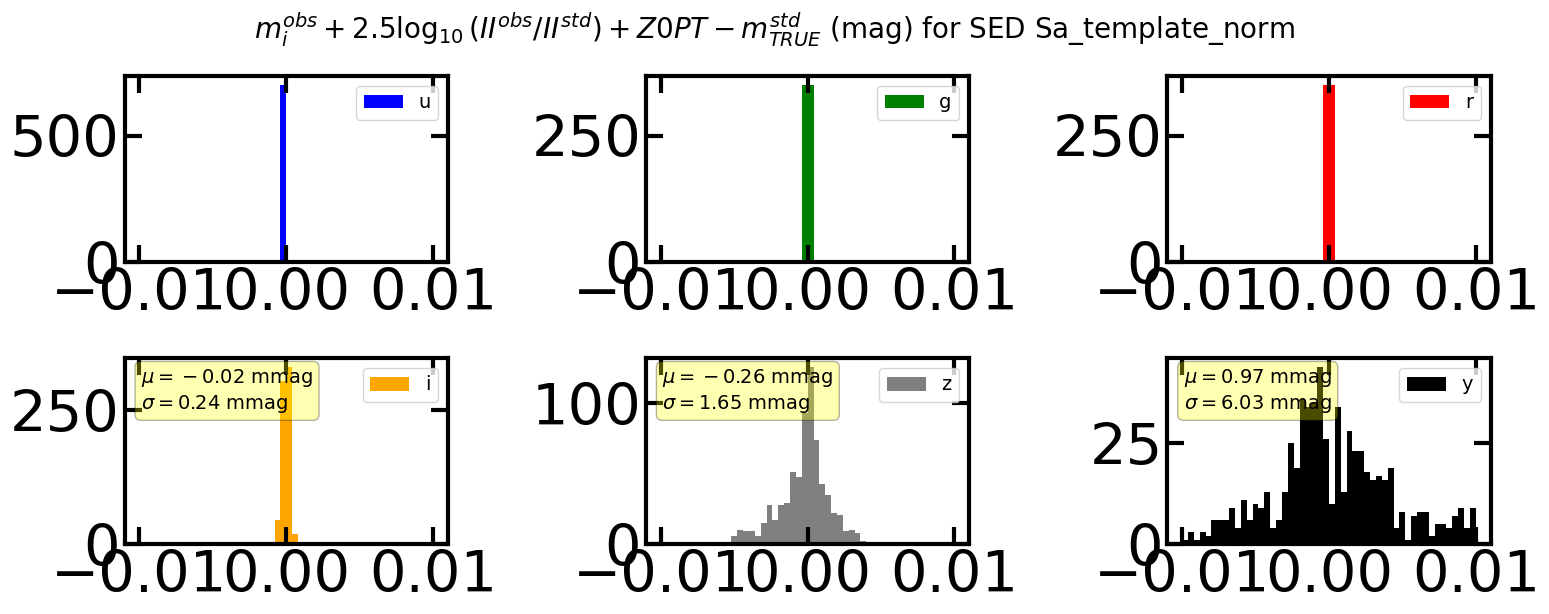

In [43]:
fig, ax = plt.subplots(2,3,figsize=(16,6))

# u
value = df["miobs_u"]+df["magratioII0_u"] + df["z0pt_u"] -df["magstd_u"]
ax[0,0].hist(value,bins=50,range=(-0.01,0.01),facecolor=filter_color[0],label=filter_tagnames[0] )
# g
value = df["miobs_g"]+df["magratioII0_g"] + df["z0pt_g"] -df["magstd_g"]
ax[0,1].hist(df["miobs_g"]+df["magratioII0_g"]-df["mistd_g"],bins=50,range=(-0.01,0.01),facecolor=filter_color[1],label=filter_tagnames[1])
# r
value = df["miobs_r"]+df["magratioII0_r"] + df["z0pt_r"] -df["magstd_r"]
ax[0,2].hist(value,bins=50,range=(-0.01,0.01),facecolor=filter_color[2],label=filter_tagnames[2])

# i
values = df["miobs_i"]+df["magratioII0_i"] + df["z0pt_i"] -df["magstd_i"]
mean = values.describe()["mean"]*1000
std = values.describe()["std"]*1000
textstr = '\n'.join((
    r'$\mu=%.2f$ mmag' % (mean, ),
    r'$\sigma=%.2f$ mmag' % (std, )))
ax[1,0].hist(values,bins=50,range=(-0.01,0.01),facecolor=filter_color[3],label=filter_tagnames[3])
ax[1,0].text(0.05, 0.95, textstr, transform=ax[1,0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


#z
values = df["miobs_z"]+df["magratioII0_z"] + df["z0pt_z"] -df["magstd_z"]
mean = values.describe()["mean"]*1000
std = values.describe()["std"]*1000
textstr = '\n'.join((
    r'$\mu=%.2f$ mmag' % (mean, ),
    r'$\sigma=%.2f$ mmag' % (std, )))
ax[1,1].hist(values,bins=50,range=(-0.01,0.01),facecolor=filter_color[4],label=filter_tagnames[4])
ax[1,1].text(0.05, 0.95, textstr, transform=ax[1,1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# y
values = df["miobs_y"]+df["magratioII0_y"] + df["z0pt_y"] -df["magstd_y"]
mean = values.describe()["mean"]*1000
std = values.describe()["std"]*1000
textstr = '\n'.join((
    r'$\mu=%.2f$ mmag' % (mean, ),
    r'$\sigma=%.2f$ mmag' % (std, )))
ax[1,2].hist(values,bins=50,range=(-0.01,0.01),facecolor=filter_color[5],label=filter_tagnames[5])
ax[1,2].text(0.05, 0.95, textstr, transform=ax[1,2].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

for ix in range(3):
    for iy in range(2):
        ax[iy,ix].legend()
plt.tight_layout()
plt.suptitle("$m_i^{obs} + 2.5\log_{10}(II^{obs}/II^{std}) + Z0PT -m_{TRUE}^{std}$ (mag)" +f" for SED {sed_name}",fontsize=20,y=1.05)

## Machine Learning

### Config

In [44]:
# temporary folders if necessary
NBDIR       = 'photoz_dp02'                            # relative path for this notebook output
TMPTOPDIR   = "/sps/lsst/groups/photoz/sylvie2024/from_MYDP0LSS"                               # always write some output in /scratch, never in user HOME 
TMPUSERDIR = TMPTOPDIR 
TMPNBDIR    = os.path.join(TMPUSERDIR,NBDIR)           # output path for this particular notebook
FLAG_READ_DATAFRAMEFROMDISK = True                     # must read data from disk

In [45]:
filename_result=f'fluxesredshift_result.pkl'
fullfilename_result=os.path.join(TMPNBDIR,filename_result)

In [46]:
# Show plots on redshift distribution
FLAG_SHOW_TRUE_REDSHIFT_DISTRIB = True

In [47]:
# Show plots to check the photometry selected for photoz
# For a pure demo on photoZ, this section can be skipped
FLAG_SHOW_PHOTOMETRY_DETECTION = True

### Start here

#### Read

In [48]:
if FLAG_READ_DATAFRAMEFROMDISK and os.path.exists(fullfilename_result):
    sql_results = pd.read_pickle(fullfilename_result)

In [49]:
data = sql_results

In [50]:
data.head()

,mt_id_truth_type,mt_match_objectId,ts_ra,ts_dec,ts_truth_type,ts_mag_r,ts_is_pointsource,ts_redshift,ts_flux_u,ts_flux_g,...,obj_r_cModelFlux,obj_i_cModelFlux,obj_z_cModelFlux,obj_y_cModelFlux,obj_u_cModelMag,obj_g_cModelMag,obj_r_cModelMag,obj_i_cModelMag,obj_z_cModelMag,obj_y_cModelMag
0,7939458371_1,1651413688361450903,61.842387,-36.524608,1,23.649401,0,0.951227,901.932007,893.604980,...,2062.920998,3226.156045,5167.702940,5953.202104,23.544281,23.413564,23.113794,22.628287,22.116756,21.963123
1,7940601535_1,1651413688361451151,61.887583,-36.523576,1,23.478600,0,1.142670,1177.569946,1248.369995,...,1555.517213,2007.930923,3577.964091,4435.082726,23.654670,23.553670,23.420313,23.143128,22.515910,22.282746
2,7938042672_1,1651413688361451083,61.949615,-36.527649,1,23.201700,0,0.576006,573.070984,878.140015,...,1943.691304,3379.122989,3879.091103,4958.231052,24.590838,24.023397,23.178432,22.577990,22.428175,22.161683
3,7937797456_1,1651413688361451150,61.887049,-36.525188,1,22.417500,0,0.442611,399.596985,1157.119995,...,4398.087847,6030.980909,6976.460761,7867.026482,25.030332,23.661947,22.291840,21.949030,21.790912,21.660473
4,7944880657_1,1651413688361451062,61.924857,-36.527904,1,24.007401,0,1.784890,648.911987,738.971008,...,752.674832,937.976640,1608.215672,2100.901486,24.924957,24.455480,24.208482,23.969520,23.384139,23.093986


In [51]:
del data['mt_id_truth_type']
del data['mt_match_objectId']
del data['ts_ra']
del data['ts_dec']
del data['ts_truth_type']
del data['ts_mag_r']
del data['ts_is_pointsource']
del data['ts_flux_u']
del data['ts_flux_g']
del data['ts_flux_r']
del data['ts_flux_i']
del data['ts_flux_z']
del data['ts_flux_y']
del data['obj_coord_ra'] 
del data['obj_coord_dec'] 
del data['obj_u_cModelFlux'] 
del data['obj_g_cModelFlux'] 
del data['obj_r_cModelFlux'] 
del data['obj_i_cModelFlux'] 
del data['obj_z_cModelFlux']
del data['obj_y_cModelFlux']

In [52]:
# for shorter names
data.rename(columns={"obj_u_cModelMag": "mag_u", "obj_g_cModelMag": "mag_g","obj_r_cModelMag": "mag_r",
                     "obj_i_cModelMag": "mag_i", "obj_z_cModelMag": "mag_z","obj_y_cModelMag": "mag_y",
                     "ts_redshift":"redshift"
                    },inplace=True)

In [53]:
data

,redshift,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y
0,0.951227,23.544281,23.413564,23.113794,22.628287,22.116756,21.963123
1,1.142670,23.654670,23.553670,23.420313,23.143128,22.515910,22.282746
2,0.576006,24.590838,24.023397,23.178432,22.577990,22.428175,22.161683
3,0.442611,25.030332,23.661947,22.291840,21.949030,21.790912,21.660473
4,1.784890,24.924957,24.455480,24.208482,23.969520,23.384139,23.093986
...,...,...,...,...,...,...,...
56173,1.181640,24.478454,24.677930,24.415583,24.230565,23.764589,23.400803
56174,0.701075,25.402165,24.514681,23.352261,22.587281,22.316529,22.082402
56175,0.714574,23.760397,23.768756,23.193998,22.345509,21.853552,21.621882
56176,0.824669,24.096307,23.557741,22.409664,21.378226,20.745974,20.503063


In [54]:
# drop NA
data = data.dropna()

In [55]:
len(data)

55564

In [56]:
pd.options.mode.chained_assignment = None  # default='warn'
data["umg"]=data["mag_u"]- data["mag_g"]
data["gmr"]=data["mag_g"]- data["mag_r"]
data["rmi"]=data["mag_r"]- data["mag_i"]
data["imz"]=data["mag_i"]- data["mag_z"]
data["zmy"]=data["mag_z"]- data["mag_y"]

array([[<Axes: title={'center': 'redshift'}>]], dtype=object)

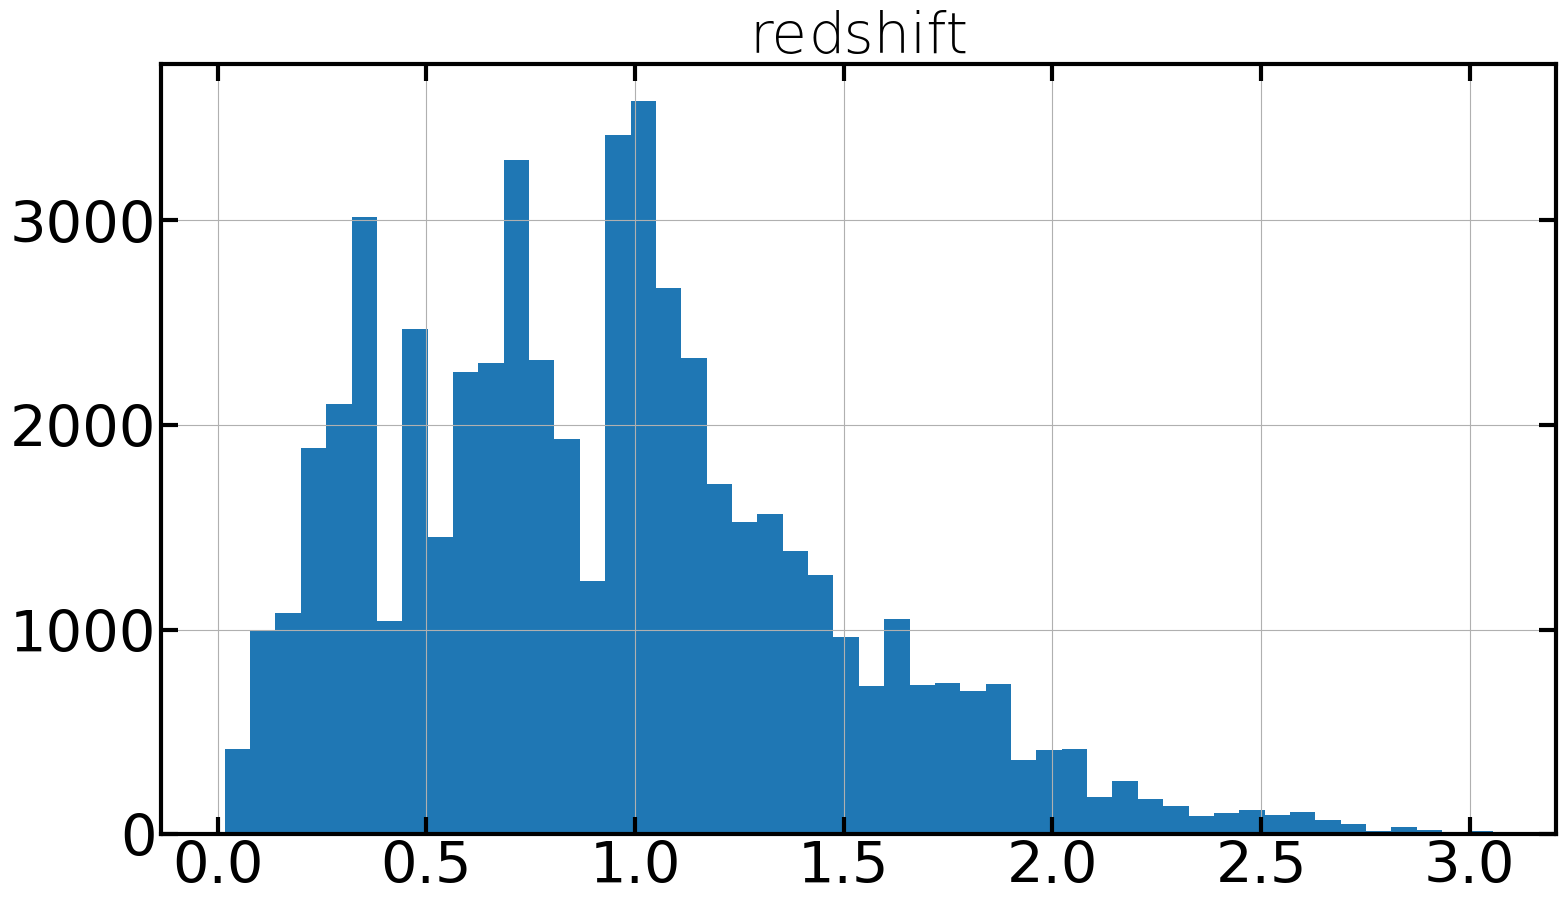

In [57]:
data.hist("redshift",bins=50)

# Machine Learning for Photo-Z estimation

# Requirements from LSST Science book:
(https://www.lsst.org/sites/default/files/docs/sciencebook/SB_3.pdf)

Photometric redshifts for LSST will be applied and calibrated over the redshift range $0 < z < 4$
for galaxies to $r  \simeq 27.5$. 
For the majority of science cases, such as weak lensing and BAO, a subset
of galaxies with $i < 25.3$ will be used. For this high S/N gold standard subset over the
redshift interval, $0 < z < 3$, the photometric redshift requirements are:

- The root-mean-square scatter in photometric redshifts, $ \sigma_z/(1+z)$, must be smaller than 0.05, with a goal of 0.02.
- The fraction of $3\sigma $  outliers at all redshifts must be below 10%.
- The bias in $e_z = (z_{photo}−z_{spec})/(1+z_{spec})$ 
must be below 0.003 (or 0.01 for combined,analyses of weak lensing and baryon acoustic oscillations); 
- The uncertainty in  $\sigma_z/(1+z)$ must also be known to similar accuracy.



### other definitions

- **the photo-z accuracy is the absolute value of the difference between the true and photometric redshifts**.

-  **the photo-z uncertainty is the standard deviation of the true redshifts** 

In [58]:
def get_stats(z_spec,z_phot,slope=0.15):
    """
    input : 
       - z_spec : spectroscopic redshift or true redshift
       - z_phot : photo-z reedshift
       - slope : slope of line defining the outliers  3 x sigma_z with sigma_z = 5%, so slope = 3 x 0.05 = 0.15 
    """
    
    mask = np.abs((z_phot - z_spec)/(1 + z_spec)) > slope
    notmask = ~mask 
    
    # Standard Deviation of the predicted redshifts compared to the data:
    #-----------------------------------------------------------------
    std_result = np.std((z_phot - z_spec)/(1 + z_spec), ddof=1)
    print('Standard Deviation: %6.4f' % std_result)
    

    # Normalized MAD (Median Absolute Deviation):
    #------------------------------------------
    nmad = 1.48 * np.median(np.abs((z_phot - z_spec)/(1 + z_spec)))
    print('Normalized MAD: %6.4f' % nmad)

    # Percentage of delta-z > 0.15(1+z) outliers:
    #-------------------------------------------
    eta = np.sum(np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15)/len(z_spec)
    print('Delta z >0.15(1+z) outliers: %6.3f percent' % (100.*eta))
    
    # Median offset (normalized by (1+z); i.e., bias:
    #-----------------------------------------------
    bias = np.median(((z_phot - z_spec)/(1 + z_spec)))
    sigbias=std_result/np.sqrt(0.64*len(z_phot))
    print('Median offset: %6.3f +/- %6.3f' % (bias,sigbias))
    
    
     # overlay statistics with titles left-aligned and numbers right-aligned
    stats_txt = '\n'.join([
        'NMAD  = {:0.2f}'.format(nmad),
        'STDEV = {:0.2f}'.format(std_result),
        'BIAS  = {:0.2f}'.format(bias),
        'ETA   = {:0.2f}'.format(eta)
    ])
    
    
    return nmad,std_result,bias,eta,stats_txt
    

In [59]:
#A function that we will call a lot: makes the zphot/zspec plot and calculates key statistics
def plot_and_stats(z_spec,z_phot):
    
    x = np.arange(0,5.4,0.05)
    outlier_upper = x + 0.15*(1+x)
    outlier_lower = x - 0.15*(1+x)

    mask = np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15
    notmask = ~mask 
    
    # Standard Deviation of the predicted redshifts compared to the data:
    #-----------------------------------------------------------------
    std_result = np.std((z_phot - z_spec)/(1 + z_spec), ddof=1)
    print('Standard Deviation: %6.4f' % std_result)

    # Normalized MAD (Median Absolute Deviation):
    #------------------------------------------
    nmad = 1.48 * np.median(np.abs((z_phot - z_spec)/(1 + z_spec)))
    print('Normalized MAD: %6.4f' % nmad)

    # Percentage of delta-z > 0.15(1+z) outliers:
    #-------------------------------------------
    eta = np.sum(np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15)/len(z_spec)
    print('Delta z >0.15(1+z) outliers: %6.3f percent' % (100.*eta))
    
    # Median offset (normalized by (1+z); i.e., bias:
    #-----------------------------------------------
    bias = np.median(((z_phot - z_spec)/(1 + z_spec)))
    sigbias=std_result/np.sqrt(0.64*len(z_phot))
    print('Median offset: %6.3f +/- %6.3f' % (bias,sigbias))
    
    # make photo-z/spec-z plot
    #------------------------
    plt.figure(figsize=(8, 8))
    
    #add lines to indicate outliers
    plt.plot(x, outlier_upper, 'k--')
    plt.plot(x, outlier_lower, 'k--')
    plt.plot(z_spec[mask], z_phot[mask], 'r+', markersize=3,  alpha=0.1)
    plt.plot(z_spec[notmask], z_phot[notmask], 'b.',  markersize=3, alpha=0.1)
    plt.plot(x, x, linewidth=1.5, color = 'red')
    plt.title('$\sigma_\mathrm{NMAD} \ = $%6.4f\n'%nmad+'$(\Delta z)>0.15(1+z) $ outliers = %6.3f'%(eta*100)+'%', fontsize=18)
    plt.xlim([0.0, 3])
    plt.ylim([0.0, 3])
    plt.xlabel('$z_{\mathrm{spec}}$', fontsize = 27)
    plt.ylabel('$z_{\mathrm{photo}}$', fontsize = 27)
    plt.grid(alpha = 0.8)
    plt.tick_params(labelsize=15)
    plt.show()
    

In [60]:
#A function that we will call a lot: makes the zphot/zspec plot and calculates key statistics
def plot2_and_stats(z_spec,z_phot):
    
    x = np.arange(0,5.4,0.05)
    outlier_upper = 0.15
    outlier_lower = - 0.15

    mask = np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15
    notmask = ~mask 
    
    # Standard Deviation of the predicted redshifts compared to the data:
    #-----------------------------------------------------------------
    std_result = np.std((z_phot - z_spec)/(1 + z_spec), ddof=1)
    print('Standard Deviation: %6.4f' % std_result)

    # Normalized MAD (Median Absolute Deviation):
    #------------------------------------------
    nmad = 1.48 * np.median(np.abs((z_phot - z_spec)/(1 + z_spec)))
    print('Normalized MAD: %6.4f' % nmad)

    # Percentage of delta-z > 0.15(1+z) outliers:
    #-------------------------------------------
    eta = np.sum(np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15)/len(z_spec)
    print('Delta z >0.15(1+z) outliers: %6.3f percent' % (100.*eta))
    
    # Median offset (normalized by (1+z); i.e., bias:
    #-----------------------------------------------
    bias = np.median(((z_phot - z_spec)/(1 + z_spec)))
    sigbias=std_result/np.sqrt(0.64*len(z_phot))
    print('Median offset: %6.3f +/- %6.3f' % (bias,sigbias))
    
    # make photo-z/spec-z plot
    #------------------------
    plt.figure(figsize=(8, 8))
    
    #add lines to indicate outliers
    plt.axhline(y=outlier_upper, ls="--",color='k')
    plt.axhline(y=outlier_lower, ls='--',color='k')
    plt.plot(z_spec[mask], (z_phot[mask]-z_spec[mask])/(1+z_spec[mask]), 'r+', markersize=3,  alpha=0.1)
    plt.plot(z_spec[notmask], (z_phot[notmask]-z_spec[notmask])/(1+z_spec[notmask]), 'b.',  markersize=3, alpha=0.1)
    plt.axhline(y=0, linewidth=1.5, color = 'red')
    plt.title('$\sigma_\mathrm{NMAD} \ = $%6.4f\n'%nmad+'$(\Delta z)>0.15(1+z) $ outliers = %6.3f'%(eta*100)+'%', fontsize=18)
    plt.xlim([0.0, 3])
    plt.ylim([-0.5, 0.5])
    plt.xlabel('$z_{\mathrm{spec}}$', fontsize = 27)
    plt.ylabel('$\Delta z/(1+z)$', fontsize = 27)
    plt.grid(alpha = 0.8)
    plt.tick_params(labelsize=15)
    plt.show()
    

In [61]:
target = data["redshift"]
features = data[["mag_u","mag_g","mag_r","mag_i","mag_z","mag_y"]]

In [62]:
Ntot = len(target)
Ntot

55564

### Split in training / test set

- speed of the notebook must be tuned with the training sample size

### number of samples to be used in training

- depending on the required speed of the demo 

In [63]:
Ntrain = 25000
Ntest = Ntot-Ntrain

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
# Test fraction
test_sample_size_fraction=Ntest/Ntot
test_sample_size_fraction

0.5500683896047801

In [66]:
# adapt the train dataset size according required running time 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_sample_size_fraction, random_state=0)

In [67]:
X_train

,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y
5976,25.535349,24.702660,23.367480,22.925201,22.714810,22.689759
52711,24.627266,24.325385,24.448757,24.128209,23.821821,23.630075
41288,25.890031,24.657034,23.612247,22.776227,22.358748,22.580800
19621,26.869693,24.204737,22.849167,21.975065,21.561269,21.254192
6831,23.927246,24.106375,23.794798,23.588691,23.046647,22.879608
...,...,...,...,...,...,...
46412,23.453401,23.625122,23.312155,22.745038,22.341317,22.145967
52998,23.549713,23.722823,23.820888,23.871670,23.465885,23.261725
43089,24.070401,23.968724,23.658184,23.012074,22.361847,22.446018
44052,25.686378,24.859971,23.672944,22.636371,22.320999,21.974828


### RandomForest regressor

- RandomForest regressor is an Enssemble regressor of type Bagging (Bootstrap and Aggregation).  

- RandomForest regressor combines the regression of multiple decision tree regressors fitted in parallel 
on bootstrapped samples from the training sample.

- Each individual decision tree is deep, meaning they individually overfit the bootstrapped samples. 

- The aggregation of the overfitting parallel decision tree model reduce the over-fitting.
- For Random Forest, each Decision Tree node feature are drawn randomly. This reduce the error correlation of the various trees.
- From this caracteristics, RandomForest is expected to be one of the best non-linear regressor on column-tabulated datasets.


- RandomForst includes a number of hyper-parameters.
- We use the hyper-parameters chosen byJeff Newmann for the DE-School at Oxford 2016.

In [68]:
from sklearn.ensemble import RandomForestRegressor
#randomforest_regressor = RandomForestRegressor(n_estimators = 50, max_depth = 30, max_features = 'auto')
randomforest_regressor = RandomForestRegressor(n_estimators = 50, max_depth = 30)

In [69]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [70]:
pipe = make_pipeline(StandardScaler(), RandomForestRegressor())

## Evaluation metrics

In [71]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import make_scorer
scoring = {'r2': make_scorer(r2_score),'mae': make_scorer(mean_absolute_error),'mse': make_scorer(mean_squared_error)}

## Definition of the $R^2$ score for a regression (not a classification)

- see https://en.wikipedia.org/wiki/Coefficient_of_determination

- The R^2 score is also called the coefficient of determination

$$
R^2 = 1 - \frac{SSR}{SST} = \frac{SSE}{SST}
$$

where:

- $SST = \sum_i (y_i - \overline{y})^2$ , for total sum of squares,
- $SSR = \sum_i (y_i - \hat{y}_i)^2$ , for the residual sum of squares,
- $SSE = SST - SSR $, is the variance explained


The fit is good when $SSR \simeq 0$, thus when $R^2$ score is 1

- another interpretation is $R^2 = corr(y_i, \hat{y}_i)^2$

## Training

In [72]:
X_train

,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y
5976,25.535349,24.702660,23.367480,22.925201,22.714810,22.689759
52711,24.627266,24.325385,24.448757,24.128209,23.821821,23.630075
41288,25.890031,24.657034,23.612247,22.776227,22.358748,22.580800
19621,26.869693,24.204737,22.849167,21.975065,21.561269,21.254192
6831,23.927246,24.106375,23.794798,23.588691,23.046647,22.879608
...,...,...,...,...,...,...
46412,23.453401,23.625122,23.312155,22.745038,22.341317,22.145967
52998,23.549713,23.722823,23.820888,23.871670,23.465885,23.261725
43089,24.070401,23.968724,23.658184,23.012074,22.361847,22.446018
44052,25.686378,24.859971,23.672944,22.636371,22.320999,21.974828


In [73]:
%%time
# We simply use the fit method, not the cross_validate to accelerate the demo 
t1 = datetime.datetime.now()
#randomforest_regressor.fit(X_train,y_train)
pipe.fit(X_train,y_train)
t2 = datetime.datetime.now()
deltat = (t2-t1).total_seconds() 
print(f"RandomForest : elapsed time {deltat:.2f} sec")

RandomForest : elapsed time 23.36 sec
CPU times: user 23.3 s, sys: 91.6 ms, total: 23.4 s
Wall time: 23.4 s


## Estimate

In [74]:
#y_pred =  randomforest_regressor.predict(X_test)
y_pred =  pipe.predict(X_test)

In [75]:
zphot= y_pred
zspec = y_test

In [76]:
r2  = r2_score(y_pred,y_test)
mae = mean_absolute_error(y_pred,y_test)
mse = mean_squared_error(y_pred,y_test)

In [77]:
msg_r2   = f"R2 score : \t\t {r2:.3f}"
msg_mae  = f"MAE mean absolute error : \t {mae:.3f}"
msg_rmsq = f"Root MSE error : \t\t {np.sqrt(mse):.3f}"

In [78]:
print(msg_r2)
print(msg_mae)
print(msg_rmsq)

R2 score : 		 0.831
MAE mean absolute error : 	 0.101
Root MSE error : 		 0.198


### Performances

In [79]:
nmad,std_result,bias,eta,stats_txt2= get_stats(y_test.values,y_pred)

Standard Deviation: 0.0987
Normalized MAD: 0.0377
Delta z >0.15(1+z) outliers:  6.485 percent
Median offset:  0.003 +/-  0.001


## Plot

Standard Deviation: 0.0987
Normalized MAD: 0.0377
Delta z >0.15(1+z) outliers:  6.485 percent
Median offset:  0.003 +/-  0.001


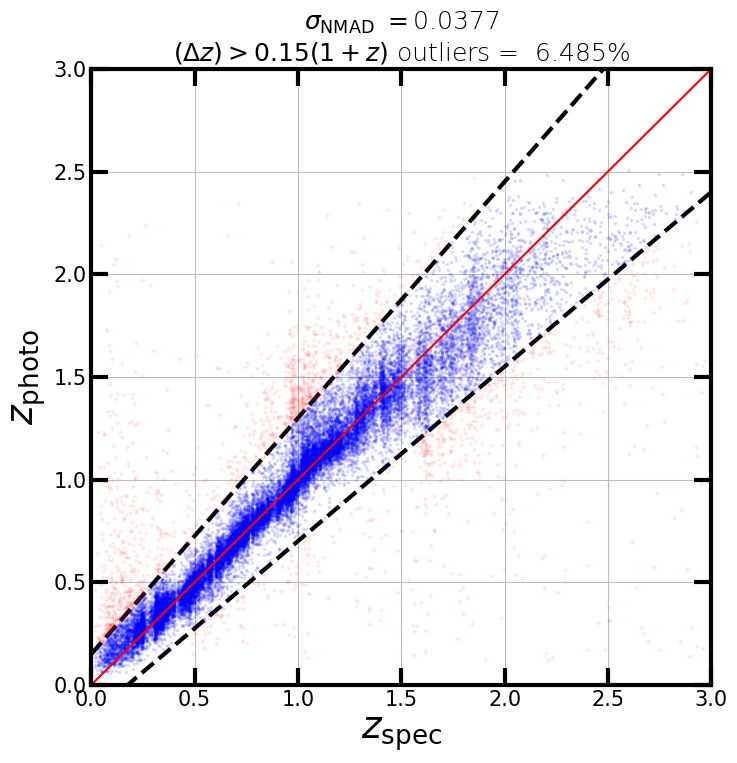

In [80]:
plot_and_stats(zspec,zphot)

Standard Deviation: 0.0987
Normalized MAD: 0.0377
Delta z >0.15(1+z) outliers:  6.485 percent
Median offset:  0.003 +/-  0.001


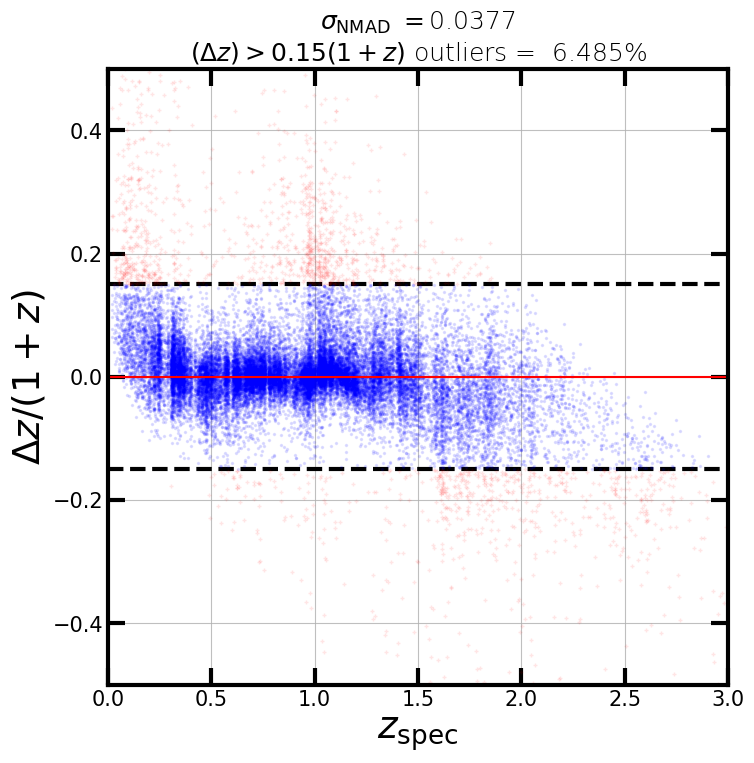

In [81]:
plot2_and_stats(zspec,zphot)

## Save model parameters in output file

In [82]:
filename_modelparams = 'randomforest_regressor_standardized.joblib'

In [83]:
dump(pipe, filename_modelparams, compress = 1 ) 

['randomforest_regressor_standardized.joblib']

## Check if the model is written correctly

In [84]:
standardized_model = load(filename_modelparams) 

In [85]:
standardized_model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [86]:
y_pred1 =  standardized_model.predict(X_test)

In [87]:
zphot= y_pred1
zspec = y_test

Standard Deviation: 0.0987
Normalized MAD: 0.0377
Delta z >0.15(1+z) outliers:  6.485 percent
Median offset:  0.003 +/-  0.001


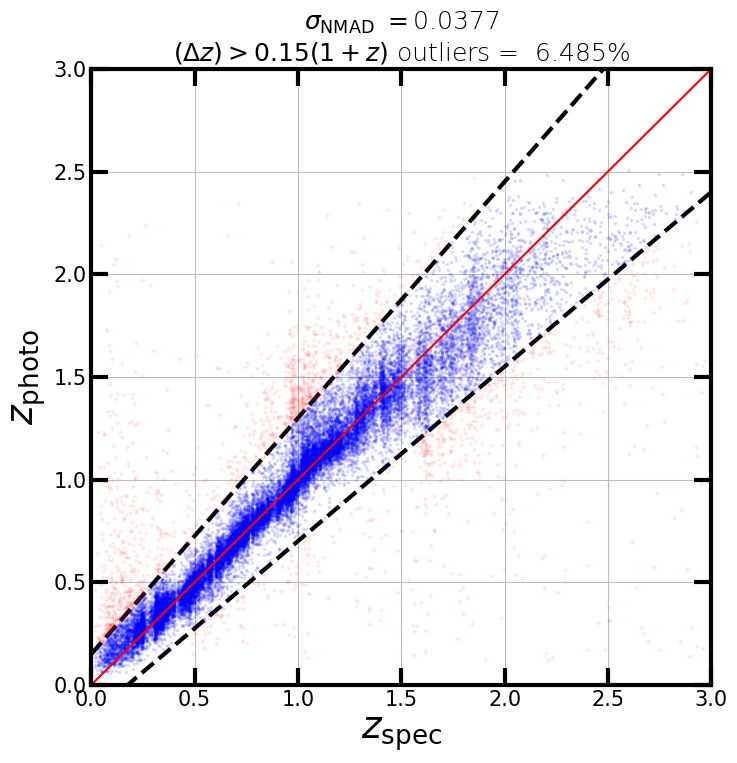

In [88]:
plot_and_stats(zspec,zphot)